# MLMNC Group Project - Team 6

Settings:

In [1]:
# SETTINGS

# fix_skewed:
# This is an automated way of excluding 13 entries out of the TRIAL data set (or any other data set that is given).
# If False, the usual data set will be taken. False is the default for this notebook and results of fix_skewed = False were used for the report.
# If True, then 13 entries will be excluded. This results in all models achieving TREMENDOUSLY BETTER RESULTS.
# Try out fix_skewed=False and then fix_skewed=True, if you dare.
fix_skewed = False

# 0 - Import of Data & Dependencies

In [2]:
import pandas as pd
import numpy as np

# for data preprocessing
from sklearn.model_selection import train_test_split

# for K_Neighbours
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# for RandomForest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# for Decision Tree
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# for neural nets
import tensorflow as tf

# for linear regression
from sklearn.linear_model import LinearRegression

# for visualizations
from sklearn import metrics
import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
audit_risk_original = pd.read_csv('https://raw.githubusercontent.com/Elmira-Rakhmetova/ML-Audit-project/main/audit_risk.csv')
trial_original = pd.read_csv('https://raw.githubusercontent.com/Elmira-Rakhmetova/ML-Audit-project/main/trial.csv')

# 1 - Data Exploration & Preparation 

In [4]:
# how does the data look like?
trial_original.head()

,Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
0,3.89,23,4.18,6,2.50,2,6.68,5.0,2,3.38,2,2,0,2,0,2,2.4,1
1,3.89,6,0.00,2,4.83,2,4.83,5.0,2,0.94,2,2,0,2,0,2,2.0,0
2,3.89,6,0.51,2,0.23,2,0.74,5.0,2,0.00,2,2,0,2,0,2,2.0,0
3,3.89,6,0.00,2,10.80,6,10.80,6.0,6,11.75,6,2,0,2,0,2,4.4,1
4,3.89,6,0.00,2,0.08,2,0.08,5.0,2,0.00,2,2,0,2,0,2,2.0,0


In [5]:
# brief data description 
trial_original.describe()

,Sector_score,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
count,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,775.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000
mean,20.184536,2.450194,3.512887,10.799988,3.131443,13.218481,5.067655,2.237113,14.137631,2.909794,2.505155,0.029639,2.061856,0.104381,2.167526,2.702577,0.626289
std,24.319017,5.678870,1.740549,50.083624,1.698042,51.312829,0.264449,0.803517,66.606519,1.597452,1.228678,0.184280,0.375080,0.531031,0.679869,0.858923,0.484100
min,1.850000,0.000000,2.000000,0.000000,2.000000,0.000000,5.000000,2.000000,0.000000,2.000000,2.000000,0.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,2.370000,0.210000,2.000000,0.000000,2.000000,0.537500,5.000000,2.000000,0.000000,2.000000,2.000000,0.000000,2.000000,0.000000,2.000000,2.000000,0.000000
50%,3.890000,0.875000,2.000000,0.405000,2.000000,1.370000,5.000000,2.000000,0.090000,2.000000,2.000000,0.000000,2.000000,0.000000,2.000000,2.400000,1.000000
75%,55.570000,2.480000,6.000000,4.160000,4.000000,7.707500,5.000000,2.000000,5.595000,4.000000,2.000000,0.000000,2.000000,0.000000,2.000000,3.250000,1.000000
max,59.850000,85.000000,6.000000,1264.630000,6.000000,1268.910000,9.000000,6.000000,935.030000,6.000000,6.000000,2.000000,6.000000,9.000000,6.000000,5.200000,1.000000


## Data preprocessing

In [6]:
trial = trial_original.copy()

In [7]:
trial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sector_score   776 non-null    float64
 1   LOCATION_ID    776 non-null    object 
 2   PARA_A         776 non-null    float64
 3   SCORE_A        776 non-null    int64  
 4   PARA_B         776 non-null    float64
 5   SCORE_B        776 non-null    int64  
 6   TOTAL          776 non-null    float64
 7   numbers        776 non-null    float64
 8   Marks          776 non-null    int64  
 9   Money_Value    775 non-null    float64
 10  MONEY_Marks    776 non-null    int64  
 11  District       776 non-null    int64  
 12  Loss           776 non-null    int64  
 13  LOSS_SCORE     776 non-null    int64  
 14  History        776 non-null    int64  
 15  History_score  776 non-null    int64  
 16  Score          776 non-null    float64
 17  Risk           776 non-null    int64  
dtypes: float64

We observe `object` datatype in column "LOCATION ID"; as it is supposed to be a numerical variable, we have to exlude the rows with text:

In [8]:
trial.LOCATION_ID.unique()

array(['23', '6', '7', '8', '13', '37', '24', '3', '4', '14', '5', '20',
       '19', '21', '22', '9', '11', '12', '29', '30', '38', '31', '2',
       '32', '16', '33', '15', '36', '34', '18', '25', '39', '27', '35',
       '40', '41', '42', '1', '28', 'LOHARU', 'NUH', 'SAFIDON', '43',
       '44', '17'], dtype=object)

In [9]:
trial = trial[(trial.LOCATION_ID != 'LOHARU')]
trial = trial[(trial.LOCATION_ID != 'NUH')]
trial = trial[(trial.LOCATION_ID != 'SAFIDON')]
trial = trial.astype(float)

We also observe 1 `nan` value in column "Money_Value" and need to exlude it: 

```python
trial = trial.dropna()
```

In [10]:
trial = trial.dropna()

## Variable analysis: correlations
The relationships between the variables are firstly analyzed through correlation matrix: 

In [11]:
trial.corr(method='pearson').style.format('{:.2f}').background_gradient()

,Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
Sector_score,1.00,-0.06,-0.22,-0.43,-0.13,-0.22,-0.15,-0.15,-0.17,-0.12,-0.32,-0.11,-0.08,-0.09,-0.12,-0.14,-0.34,-0.38
LOCATION_ID,-0.06,1.00,-0.00,0.08,0.01,0.13,0.01,0.01,-0.02,-0.07,0.11,-0.11,0.01,-0.00,-0.08,-0.05,0.09,0.05
PARA_A,-0.22,-0.00,1.00,0.50,0.16,0.36,0.27,0.13,0.14,0.45,0.29,0.13,0.05,0.04,0.12,0.17,0.43,0.29
SCORE_A,-0.43,0.08,0.50,1.00,0.25,0.57,0.30,0.24,0.27,0.21,0.48,0.09,0.09,0.09,0.18,0.26,0.72,0.67
PARA_B,-0.13,0.01,0.16,0.25,1.00,0.35,0.99,0.21,0.23,0.12,0.31,0.08,0.04,0.04,0.20,0.32,0.40,0.16
SCORE_B,-0.22,0.13,0.36,0.57,0.35,1.00,0.38,0.28,0.31,0.20,0.57,-0.01,0.10,0.09,0.20,0.31,0.90,0.51
TOTAL,-0.15,0.01,0.27,0.30,0.99,0.38,1.00,0.22,0.24,0.17,0.34,0.09,0.05,0.05,0.21,0.33,0.43,0.19
numbers,-0.15,0.01,0.13,0.24,0.21,0.28,0.22,1.00,0.91,0.19,0.45,0.12,-0.00,0.04,0.20,0.21,0.50,0.20
Marks,-0.17,-0.02,0.14,0.27,0.23,0.31,0.24,0.91,1.00,0.22,0.51,0.15,0.00,0.04,0.23,0.25,0.57,0.23
Money_Value,-0.12,-0.07,0.45,0.21,0.12,0.20,0.17,0.19,0.22,1.00,0.39,0.03,0.02,0.03,0.08,0.11,0.29,0.16


In [12]:
trial.corr(method='spearman').style.format('{:.2f}').background_gradient()

,Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
Sector_score,1.00,-0.02,-0.39,-0.38,-0.14,-0.10,-0.31,-0.07,-0.07,-0.17,-0.14,-0.15,-0.08,-0.09,-0.05,-0.05,-0.31,-0.37
LOCATION_ID,-0.02,1.00,0.07,0.07,0.10,0.11,0.11,-0.03,-0.03,0.06,0.09,-0.09,0.00,-0.01,-0.03,-0.03,0.07,0.05
PARA_A,-0.39,0.07,1.00,0.91,0.53,0.54,0.82,0.28,0.28,0.46,0.45,0.08,0.10,0.10,0.27,0.27,0.72,0.65
SCORE_A,-0.38,0.07,0.91,1.00,0.54,0.56,0.79,0.29,0.29,0.48,0.49,0.08,0.10,0.10,0.28,0.28,0.77,0.69
PARA_B,-0.14,0.10,0.53,0.54,1.00,0.83,0.85,0.32,0.32,0.58,0.55,-0.04,0.07,0.06,0.30,0.30,0.72,0.46
SCORE_B,-0.10,0.11,0.54,0.56,0.83,1.00,0.78,0.33,0.33,0.58,0.57,-0.00,0.10,0.09,0.32,0.32,0.82,0.53
TOTAL,-0.31,0.11,0.82,0.79,0.85,0.78,1.00,0.32,0.32,0.59,0.55,0.02,0.10,0.10,0.30,0.30,0.84,0.69
numbers,-0.07,-0.03,0.28,0.29,0.32,0.33,0.32,1.00,1.00,0.42,0.51,0.14,0.03,0.05,0.23,0.23,0.46,0.24
Marks,-0.07,-0.03,0.28,0.29,0.32,0.33,0.32,1.00,1.00,0.42,0.51,0.14,0.03,0.05,0.23,0.23,0.46,0.24
Money_Value,-0.17,0.06,0.46,0.48,0.58,0.58,0.59,0.42,0.42,1.00,0.80,0.06,0.12,0.13,0.31,0.31,0.68,0.46


**Observations based on the correlation matrix:**
*   the difference between the correlation coefficients computed with Pearson and Spearman methods indicates the non-linear relationships between the variables; 
*   the output variable Risk is positively correlated with all the input variables except for Sector_score;
*   the output variable Risk is highly correlated (Spearman coefficient > 0.50) with the following variables: PARA_A, SCORE_A, SCORE_B, TOTAL, and Score (highest correlation of 0.86);
*   as for the correlations between the inputs, we observe the highest correlations (Spearman coefficient >= 0.80) between the variables PARA_A and SCORE_A (0.91), PARA_B and SCORE_B (0.83), TOTAL and PARA_A (0.82), TOTAL and PARA_B (0.85), LOSS_SCORE and Loss (0.98), Marks and numbers (1.00), MONEY_Marks and Money_Value (0.80), History_score and History (1.00).

**Assumption:** some of the high correlation coefficients between the variables might suggest that in some pairs of the attributes (e.g. PARA_A & SCORE_A) one variable is derived from another one. We will double check this assumption via applying RandomForestRegressor to better understand the relationships between the variables.

## Varible analysis: modelling

In [13]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

variables = trial.columns 

x_explains_y = pd.DataFrame(index=variables, columns=variables, dtype=np.float)
for xname in variables:
    for yname in variables:
        X = trial[[xname]].values
        y = trial[yname]
        
        rf = RandomForestRegressor(n_estimators=50, oob_score=True)
        rf.fit(X, y)
        
        x_explains_y.loc[xname, yname] = rf.oob_score_

In [14]:
x_explains_y.style.background_gradient(low=0, high=1).format('{:.2f}')

,Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
Sector_score,1.00,0.01,0.04,0.26,0.07,0.20,0.07,0.05,0.07,0.02,0.28,0.07,-0.00,-0.00,0.02,0.02,0.27,0.21
LOCATION_ID,-0.02,1.00,-0.02,-0.03,-0.02,-0.01,-0.02,-0.13,0.04,0.01,0.01,0.27,-0.04,-0.02,-0.03,-0.04,0.02,0.02
PARA_A,0.02,-0.29,0.98,1.00,-0.04,0.10,-0.24,-0.27,-0.38,-0.43,-0.08,-0.27,-0.37,-0.36,-0.30,-0.39,0.35,0.43
SCORE_A,0.18,0.00,0.26,1.00,0.06,0.33,0.09,0.05,0.07,0.03,0.22,0.00,-0.00,-0.00,0.02,0.07,0.52,0.53
PARA_B,-0.04,-0.27,-0.18,0.09,0.35,0.79,0.37,-0.03,-0.24,-0.15,0.34,-0.34,-0.11,-0.04,-0.48,-0.30,0.72,0.14
SCORE_B,0.04,0.01,0.11,0.32,0.12,1.00,0.14,0.07,0.09,0.03,0.32,-0.01,0.00,0.00,0.04,0.09,0.81,0.29
TOTAL,-0.08,-0.33,-0.16,0.55,0.33,0.65,0.41,-0.21,-0.24,-0.53,0.16,-0.37,-0.33,-0.38,-0.33,-0.47,0.71,0.39
numbers,0.03,0.00,0.01,0.08,0.04,0.11,0.05,0.88,1.00,0.03,0.27,-0.00,-0.00,-0.01,-0.00,0.02,0.34,0.06
Marks,0.03,0.00,0.01,0.08,0.03,0.11,0.04,0.82,1.00,0.03,0.27,0.01,-0.00,-0.01,0.03,0.05,0.34,0.06
Money_Value,-0.04,-0.26,-0.01,0.07,-0.89,0.17,-0.60,0.06,-0.02,0.98,1.00,-0.22,-0.23,-0.27,-0.27,-0.37,0.44,0.13


**Observations based on the model:** 


*   A number of variables are not independent and can be explained through other variables in the dataset;
*   Such input variables are as follows: SCORE_A (explained by: PARA_A), (PARA_B), Marks (numbers), MONEY_Marks (Money_Value), LOSS_SCORE (Loss), History_score (History); 
*   The same applies to the variable pair Score and Risk: total risk score of a firm calculated through the analytical procedure (variable Score) fully explains the risk class assigned to a firm (output variable Risk). 




## Variables short-list

For the modelling purposes, we select the subset of the truly independent variables, which are presented in the list below:

- **Sector_score**: Historical risk score value of the sector; 
- **PARA_A**: Discrepancy found in the plannedexpenditure of inspection and summary report A in Rs (in crore)
- **PARA_B**: Discrepancy found in the unplannedexpenditure of inspection and summary report B in Rs (in crore)
- **TOTAL**: Total amount of discrepancy found in other reports Rs (in crore)
- **numbers**: Historical discrepancy score
- **Money_Value**: Amount of money involved in misstatements in the past audits
- **District**: Historical risk score of a district in the last 10 years
- **Loss**: Amount of loss suffered by the firm last year
- **History**: Average historical loss suffered by firm in the last 10 years
- **Risk** *(output variable)*: Risk Class assigned to an audit-case 

As `LOCATION_ID` attribute does not hold any relevant information in terms of identifying whether a firm is potentially fraudulent or not, we will not include in the classification model; however, we will use it in the end to cluster potentially fraudulent firms and see whether they tend to concentrate in some location(s)

In [15]:
xnames = ['Sector_score', 'PARA_A','PARA_B', 'TOTAL', 'numbers', 'Money_Value', 'District', 'Loss', 'History']
yname = 'Risk'

## Normalizing data

To get better results for our model, we need to normalize the input variables:

In [16]:
# setting x and y
x = trial[xnames]
y = trial[yname].astype(int) # y values can only be 1 or 0, that is why they are changed into an integer

# converting values into a numpy array (not sure if this step is necessary)
x = np.array(x)
y = np.array(y)

In [17]:
# this uses the keras normalizing method
x = tf.keras.utils.normalize(x)

## Splitting data

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) # train_test_split was imported in the beginning

## Final checkups
Here's a summary of what the data looks like now

In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(540, 9)
(540,)
(232, 9)
(232,)


# 2 - Preparing data and environment

## Creating data pre-processing class

In [20]:
class dataPreprocessing:
  def __init__(self, dataframe, xnames=['Sector_score', 'PARA_A','PARA_B', 'TOTAL', 'numbers', 'Money_Value', 'District', 'Loss', 'History'], yname='Risk', normalize=False, convert_to_array=True, test_size=0.3, fix_skewed=False):
    # save some settings as attributed
    self.xnames = xnames
    self.yname = yname
    
    self.data = dataframe.copy()
    # if wanted, weird entries (skewed entries) will be excluded from the data set
    if fix_skewed is True:
      ds = self.data
      # creating a dataframe ds that includes all entries that are skewed. The following conditions get exactly those 13 entries
      ds = ds[(ds.Sector_score==3.89) & (ds.Risk==0) & ((ds.PARA_B==2.97) | (ds.PARA_B==1.05) | (ds.PARA_B==1.03) | (ds.PARA_B==2.02) | (ds.PARA_B==1.0) | (ds.PARA_B==2.27) | (ds.PARA_B==1.1) | (ds.PARA_B==1.88) | (ds.PARA_B==1.61) | (ds.PARA_B==1.02) | (ds.PARA_B==1.76) | (ds.PARA_B==4.83))]
      ds2 = dataframe.copy()
      # ds2 is a new dataframe. Now, all elements that are in ds will be filtered out of the dataframe using the following line:
      ds2 = ds2[(~ds2.isin(ds))]
      self.data = ds2

    # drop na values
    self.data = self.data.dropna()
    # get rid of weird locations
    self.data = self.data[(self.data.LOCATION_ID != 'LOHARU')]
    self.data = self.data[(self.data.LOCATION_ID != 'NUH')]
    self.data = self.data[(self.data.LOCATION_ID != 'SAFIDON')]
    self.data = self.data.astype(float)

    # setting x and y
    self.x = self.data[xnames]
    self.y = self.data[yname]

    # converting values into a numpy array (not sure if this step is necessary)
    # Default: True
    if convert_to_array is True:
      self.x = np.array(self.x)
      self.y = np.array(self.y)

    # this uses the keras normalizing method
    # Default: False
    if normalize is True:
      self.x = tf.keras.utils.normalize(self.x)

    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_size, random_state=42) # train_test_split was imported in the beginning

## Generating datasets

*define whether the dataframes should fix the 13 skewed entries (found out from the NO-ML model):*

In [21]:
# set to False by default. Switch to True to see what happens when the 13 skewed entries are deleted.
# this setting is made at the TOP of the notebook. Please change it there
if fix_skewed is None:
  fix_skewed = False

In [22]:
# default data:
trial = dataPreprocessing(trial_original, fix_skewed=fix_skewed) # all default values
trial_n = dataPreprocessing(trial_original, fix_skewed=fix_skewed) # all default values. Normalized.

# stripping TOTAL and Sector_Score
trial2 = dataPreprocessing(trial_original, ['PARA_A', 'PARA_B', 'numbers', 'Money_Value', 'District', 'Loss', 'History'], fix_skewed=fix_skewed)
trial2_n = dataPreprocessing(trial_original, ['PARA_A', 'PARA_B', 'numbers', 'Money_Value', 'District', 'Loss', 'History'], normalize=True, fix_skewed=fix_skewed)

trial_r = dataPreprocessing(trial_original, yname='Score', fix_skewed=fix_skewed) # dataset for regressions.
trial_r_n = dataPreprocessing(trial_original, yname='Score', normalize=True, fix_skewed=fix_skewed) # dataset for regressions. Normalized.
print("data ready")

data ready


## Creating functions for visualisations

In [23]:
def receiver_operating_characteristic(model, x_data, y_data, name="model"):
  plt.figure()
  # Compute False postive rate, and True positive rate
  fpr, tpr, thresholds = metrics.roc_curve(y_data, model.predict_proba(x_data)[:,1])
  # Calculate Area under the curve to display on the plot
  auc = metrics.roc_auc_score(y_data,model.predict(x_data))
  # Now, plot the computed values
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
  # Custom settings for the plot 
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('1-Specificity(False Positive Rate)')
  plt.ylabel('Sensitivity(True Positive Rate)')
  plt.title(name+': Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()


# plotting feature importance (for sklearn models):
def plot_feature_importances(model, data):
    cols=data.xnames
    plt.figure(figsize=(8,8))
    n_features = data.x.shape[1]
    plt.barh(range(n_features), model.feature_importances_, height=0.5,align='center')
    plt.yticks(np.arange(n_features), cols)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


# Plot the confusion matrix for classification models
def confusion_matrix_visualization(model, x_data, y_data, name="model", raw=0):
  cm_r = confusion_matrix(y_data, model.predict(x_data))
  if raw==0:
    #plt.title(name+': Confusion matrix')
    sns.set(font_scale=1.7)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    map = sns.heatmap(cm_r,annot=True,fmt="d", cbar=False, cmap=cmap)
    #plt.show()
  else:
    tn, fp, fn, tp = cm_r.ravel()
    print('true negatives:', tn)
    print('false positives:', fp)
    print('false negatives:', fn)
    print('true positives:', tp)


# Plot the confusion matrix for own data (same as the other function, only takes other inputs)
def confusion_matrix_visualization_raw(y_data_true, y_data_predict, name="model", raw=0):
  cm_r = confusion_matrix(y_data_true, y_data_predict)
  if raw==0:
    #plt.title(name+': Confusion matrix')
    sns.set(font_scale=1.7)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    map = sns.heatmap(cm_r,annot=True,fmt="d", cbar=False, cmap=cmap)
    #plt.show()
  else:
    tn, fp, fn, tp = cm_r.ravel()
    print('true negatives:', tn)
    print('false positives:', fp)
    print('false negatives:', fn)
    print('true positives:', tp)

## Creating functions for regression models (to convert)

In [24]:
# converting regression model data into classification data
# the threshold defines at which point a value should be classified as 1
# also calculates accuracy
def convert_reg_to_class(y_data_true, y_data_predict, threshold=2.1):
  # switching predicted y values
  y_data_predict = y_data_predict.copy()
  y_data_predict = np.reshape(y_data_predict, (len(y_data_predict),))
  for e,value in enumerate(y_data_predict):
    if value>=threshold:
      y_data_predict[e] = 1
    else:
      y_data_predict[e] = 0

  # switching true y values
  y_data_true = y_data_true.copy() # copying the data just to make sure it is not in any class
  y_data_true = np.reshape(y_data_true, (len(y_data_true),))
  for e,value in enumerate(y_data_true): #trial_r_n.y_test
    if value>2:
      y_data_true[e] = 1
    else:
      y_data_true[e] = 0

  # calculating accuracy
  accuracy = 0
  for e,i in enumerate(y_data_predict):
    if i==y_data_true[e]:
      accuracy = accuracy + 1
  accuracy = accuracy / len(y_data_predict)
  
  return {'y_data_true':y_data_true, 'y_data_predict':y_data_predict, 'accuracy':accuracy}

# 3 - Modelling & Evaluation 



## 3.1 K_Neighbours

In [25]:
def k_neighbors(data, grid_params={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, cv=3, n_jobs=-1, verbose=0):

  gs = GridSearchCV (KNeighborsClassifier(), grid_params, verbose = verbose, cv = cv, n_jobs = n_jobs)
  gs.fit(data.x_train, data.y_train)
  print(gs.score(data.x_train, data.y_train), gs.score(data.x_test, data.y_test))
  return gs

In [26]:
# testing
k_0 = k_neighbors(trial)
k_1 = k_neighbors(trial_n)
k_2 = k_neighbors(trial2)
k_3 = k_neighbors(trial2_n)

1.0 0.9612068965517241
1.0 0.9612068965517241
1.0 0.9568965517241379
0.9740740740740741 0.9612068965517241


```
# Results stay the same. trial outperforms.
1.0 0.9612068965517241
1.0 0.9612068965517241
1.0 0.9568965517241379
0.9740740740740741 0.9612068965517241
```

VISUALIZATION

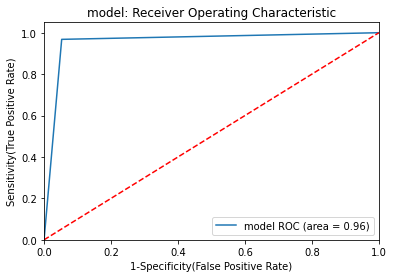

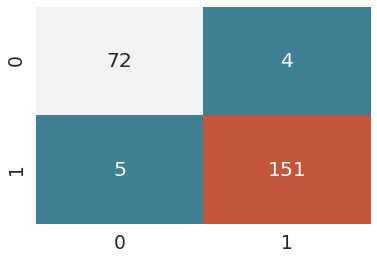

In [27]:
# visualization with dataset trial (not normalized, both perform equally well)
receiver_operating_characteristic(k_0, trial.x_test, trial.y_test)
confusion_matrix_visualization(k_0, trial.x_test, trial.y_test)

## 3.2 RandomForest (RF)

In [28]:
# Old model:
#rf_model = RandomForestClassifier()
#rf_model.fit(x_train, y_train)
#print(rf_model.score(x_train, y_train), rf_model.score(x_test, y_test))

# optimized model
def random_forest_classifier(data, n_estimators=[20,50,100,200], max_depth=['None',8,9,10,11], cv=10, n_jobs=-1, verbose=0):
  grid_params = {'max_features': ['auto','sqrt','log2'], 'n_estimators' : n_estimators, 'max_depth' :max_depth, 'criterion': ['gini','entropy']}
  gs = GridSearchCV (RandomForestClassifier(), grid_params, verbose = verbose, cv = cv, n_jobs = n_jobs)
  gs_results = gs.fit(data.x_train, data.y_train)
  print(gs.score(data.x_train, data.y_train), gs.score(data.x_test, data.y_test))
  return gs

In [29]:
# testing
r_0 = random_forest_classifier(trial)
r_1 = random_forest_classifier(trial_n)
r_2 = random_forest_classifier(trial2)
r_3 = random_forest_classifier(trial2_n)

1.0 0.978448275862069
1.0 0.978448275862069
1.0 0.9698275862068966
1.0 0.9741379310344828


```
# Results change with re-run. Generally, all are the same. Trial2 outperforms a bit.
0.9981481481481481 0.9698275862068966
0.9944444444444445 0.9698275862068966
0.9944444444444445 0.9698275862068966
0.9962962962962963 0.9741379310344828
```

VISUALIZATION

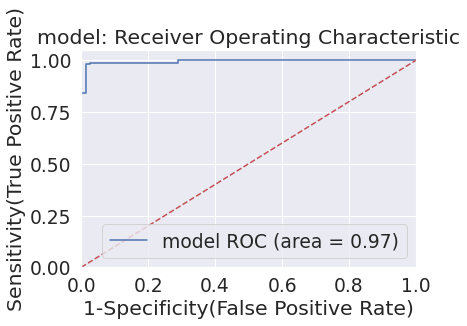

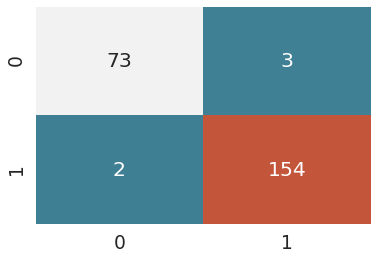

In [30]:
# visualization with dataset trial_n (normalized, because it works better)
receiver_operating_characteristic(r_1, trial_n.x_test, trial_n.y_test)
confusion_matrix_visualization(r_1, trial_n.x_test, trial_n.y_test)

## 3.3 DecisionTree (DT)

In [31]:
def decision_tree(data, max_depth=[8,9,10,11], min_samples_split=range(2,10), min_samples_leaf=range(1,5), cv=10, n_jobs=-1, verbose=0):
  grid_params = {'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf, 'max_depth':max_depth, 'criterion': ['gini','entropy']}
  gs = GridSearchCV (DecisionTreeClassifier(), grid_params, verbose = verbose, cv = cv)
  gs_results = gs.fit(data.x_train, data.y_train)
  print(gs.score(data.x_train, data.y_train), gs.score(data.x_test, data.y_test))
  return gs

In [32]:
# testing
dt_0 = decision_tree(trial)
dt_1 = decision_tree(trial_n)
dt_2 = decision_tree(trial2)
dt_3 = decision_tree(trial2_n)

0.9925925925925926 0.9655172413793104
1.0 0.9698275862068966
0.9944444444444445 0.9741379310344828
0.9944444444444445 0.9612068965517241


```
# Results stay the same. trial outperforms
1.0 0.9741379310344828
1.0 0.9741379310344828
1.0 0.9698275862068966
1.0 0.9655172413793104
```

VISUALIZATION

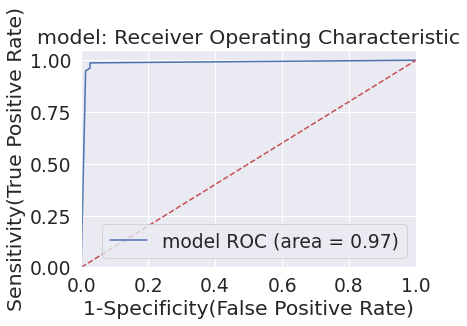

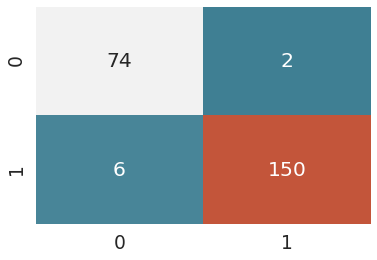

In [33]:
# visualization with dataset trial (not normalized, both perform equally well)
#plot_feature_importances(dt_0, trial)
receiver_operating_characteristic(dt_0, trial.x_test, trial.y_test)
confusion_matrix_visualization(dt_0, trial.x_test, trial.y_test)

Computation of raw confusion matrix:

In [34]:
confusion_matrix_visualization(dt_0, trial.x_test, trial.y_test, raw=1)

true negatives: 74
false positives: 2
false negatives: 6
true positives: 150


## 3.4 Neural Network (NN)

Sources:

https://www.tensorflow.org/tutorials/load_data/csv

In [35]:
def neural_network(data, epochs=1000, verbose=0):
  nn_model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(len(data.xnames))),
  tf.keras.layers.Dense(2)
  ])

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  nn_model.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  result = nn_model.fit(data.x_train, data.y_train, epochs=epochs, verbose=verbose)
  print(nn_model.evaluate(data.x_train,  data.y_train)[1] ,nn_model.evaluate(data.x_test,  data.y_test, verbose=0)[1]) # the [1] leaves out the loss and only shows accuracy
  return nn_model

In [36]:
# testing
nn_0 = neural_network(trial)
nn_1 = neural_network(trial_n)
nn_2 = neural_network(trial2)
nn_3 = neural_network(trial2_n)

17/17 [==============================] - 0s 2ms/step - loss: 0.1093 - accuracy: 0.9685
0.9685184955596924 0.9267241358757019
17/17 [==============================] - 0s 2ms/step - loss: 0.1089 - accuracy: 0.9685
0.9685184955596924 0.9267241358757019
17/17 [==============================] - 0s 2ms/step - loss: 0.1122 - accuracy: 0.9685
0.9685184955596924 0.9482758641242981
17/17 [==============================] - 0s 2ms/step - loss: 0.1527 - accuracy: 0.9593
0.9592592716217041 0.931034505367279


```
# Results change with re-run. trial2 outperforms.
17/17 [==============================] - 0s 2ms/step - loss: 0.1080 - accuracy: 0.9685
0.9685184955596924 0.931034505367279
17/17 [==============================] - 0s 2ms/step - loss: 0.1085 - accuracy: 0.9685
0.9685184955596924 0.9267241358757019
17/17 [==============================] - 0s 2ms/step - loss: 0.1118 - accuracy: 0.9685
0.9685184955596924 0.943965494632721
17/17 [==============================] - 0s 2ms/step - loss: 0.1544 - accuracy: 0.9574
0.9574074149131775 0.9267241358757019
```

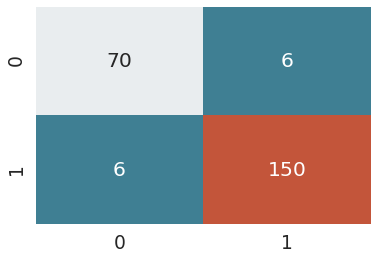

In [37]:
# visualization with dataset trial2 (not normalized, for some reason this works better)
confusion_matrix_visualization_raw(trial2.y_test, np.argmax(nn_2.predict(trial2.x_test), axis=1))

## 3.5 Deep Neural Network (DNN)

In [38]:
def deep_neural_network(data, model=[['Dense',50, 'relu'], ['Dropout', 0.2], ['Dense', '20', 'relu']], epochs=1000, verbose=0):
  # getting correct model
  dnn_model = tf.keras.models.Sequential(tf.keras.layers.InputLayer(input_shape=(len(data.xnames))))
  for layer in model:
    if layer[0]=='Dense':
      dnn_model.add(tf.keras.layers.Dense(layer[1], activation=layer[2]))
    elif layer[0]=='Dropout':
      dnn_model.add(tf.keras.layers.Dropout(layer[1]))

  # adding last layer
  dnn_model.add(tf.keras.layers.Dense(2))

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  dnn_model.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  result = dnn_model.fit(data.x_train, data.y_train, epochs=epochs, verbose=verbose)
  print(dnn_model.evaluate(data.x_train,  data.y_train, verbose=0)[1], dnn_model.evaluate(data.x_test,  data.y_test, verbose=0)[1])
  return dnn_model

In [39]:
# testing
dnn_0 = deep_neural_network(trial)
dnn_1 = deep_neural_network(trial_n)
dnn_2 = deep_neural_network(trial2)
dnn_3 = deep_neural_network(trial2_n)

0.9962962865829468 0.9698275923728943
0.9888888597488403 0.9741379022598267
0.9981481432914734 0.9741379022598267
0.9925925731658936 0.9655172228813171


```
# Results change with re-run. Normalized performs better.
0.9962962865829468 0.9698275923728943
0.9962962865829468 0.9741379022598267
0.9962962865829468 0.9741379022598267
0.9907407164573669 0.9741379022598267
```

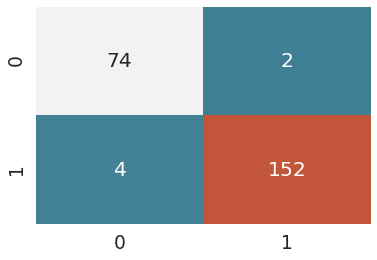

In [40]:
# visualization with dataset trial2 (not normalized, for some reason this works better)
confusion_matrix_visualization_raw(trial2.y_test, np.argmax(dnn_2.predict(trial2.x_test), axis=1))

##3.6 Regression model: Linear Regression
Instead of using `Risk` as y variable, we could also use `Score` and make a regression out of this model.

For this, we will have to use a different dataset `trial_r` and `trial_r_n` (specified above).

**Regressions cannot give you an "accuracy" on your dataset. Instead they tell you the deviation from the y values. That is why, in order to compare the regression models with the classification models, we have to convert the regression models using a threshold.**

In [41]:
def linear_regression(data):
  reg_model = LinearRegression()
  reg_model.fit(data.x_train, data.y_train)
  print("Loss:", reg_model.score(data.x_train, data.y_train), reg_model.score(data.x_test, data.y_test))
  return reg_model

In [42]:
# testing
lr_0 = linear_regression(trial_r)
lr_1 = linear_regression(trial_r_n)

# converting regression to classification values
result0 = convert_reg_to_class(trial_r.y_train, lr_1.predict(trial_r.x_train))
result1 = convert_reg_to_class(trial_r.y_test, lr_1.predict(trial_r.x_test))
print("Accuracy at 2.1 theshold:", result0['accuracy'], result1['accuracy'])

# converting normalized regression to classification values
result0 = convert_reg_to_class(trial_r_n.y_train, lr_1.predict(trial_r_n.x_train))
result1 = convert_reg_to_class(trial_r_n.y_test, lr_1.predict(trial_r_n.x_test))
print("Accuracy at 2.1 theshold:", result0['accuracy'], result1['accuracy'])

Loss: 0.669496188417347 -2.591240581829344
Loss: 0.809126412429765 0.7414148690717144
Accuracy at 2.1 theshold: 0.6944444444444444 0.6853448275862069
Accuracy at 2.1 theshold: 0.6907407407407408 0.7112068965517241


```
# Results stay the same. trial_r_n outperforms.
Loss: 0.669496188417347 -2.591240581829344
Loss: 0.809126412429765 0.7414148690717144
Accuracy at 2.1 theshold: 0.6944444444444444 0.6853448275862069
Accuracy at 2.1 theshold: 0.6907407407407408 0.7112068965517241
```

{'threshold': 2.24, 'accuracy': 0.8793103448275862}
true negatives: 70
false positives: 6
false negatives: 22
true positives: 134


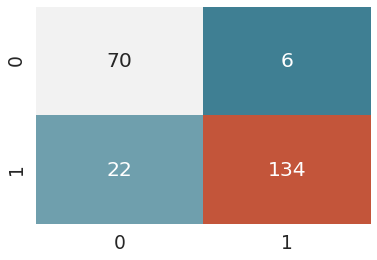

In [43]:
# Finding the right threshold (for normalized data set because it performs much better):
best_threshold = {'threshold':0, 'accuracy':0} # pre-defining data

for i in range(int(1.8*1000), int(3.0*1000)):
  # trying the current threshold
  result = convert_reg_to_class(trial_r_n.y_test, lr_1.predict(trial_r_n.x_test), float(i/1000))
  # checking if the current threshold is the best one
  if best_threshold['accuracy'] < result['accuracy']:
    best_threshold = {'threshold':float(i/1000), 'accuracy':result['accuracy']}

print(best_threshold)



# visualization (using the best threshold)
result = convert_reg_to_class(trial_r_n.y_test, lr_1.predict(trial_r_n.x_test), best_threshold['threshold'])

confusion_matrix_visualization_raw(result['y_data_true'], result['y_data_predict'])
confusion_matrix_visualization_raw(result['y_data_true'], result['y_data_predict'], raw=1)

```
{'threshold': 2.24, 'accuracy': 0.8793103448275862}
```

## 3.7 Regression model: Deep Neural Network
Instead of using `Risk` as y variable, we could also use `Score` and make a regression out of this model.

For this, we will have to use a different dataset (specified above).

In [44]:
def deep_neural_network_regression(data, model=[['Dense',50, 'relu'], ['Dropout', 0.2], ['Dense', '20', 'relu']], epochs=1000, verbose=0):
  # getting correct model
  dnn_model = tf.keras.models.Sequential(tf.keras.layers.InputLayer(input_shape=(len(data.xnames))))
  for layer in model:
    if layer[0]=='Dense':
      dnn_model.add(tf.keras.layers.Dense(layer[1], activation=layer[2]))
    elif layer[0]=='Dropout':
      dnn_model.add(tf.keras.layers.Dropout(layer[1]))

  # adding last layer
  dnn_model.add(tf.keras.layers.Dense(1))

  dnn_model.compile(optimizer='adam',
                loss="mean_absolute_error") # , metrics=['accuracy']

  result = dnn_model.fit(data.x_train, data.y_train, epochs=epochs, verbose=verbose)
  print('Loss:', dnn_model.evaluate(data.x_train,  data.y_train, verbose=0), dnn_model.evaluate(data.x_test,  data.y_test, verbose=0))
  return dnn_model

In [45]:
# testing
dnnr_0 = deep_neural_network_regression(trial_r)
dnnr_1 = deep_neural_network_regression(trial_r_n)

Loss: 0.15358935296535492 0.2074350118637085
Loss: 0.09962876886129379 0.14595657587051392


In order to compare the regression results with the classification results, the regression needs to be converted into a 1 or 0 classification:

Accuracy:  0.9482758620689655
true negatives: 67
false positives: 9
false negatives: 3
true positives: 153


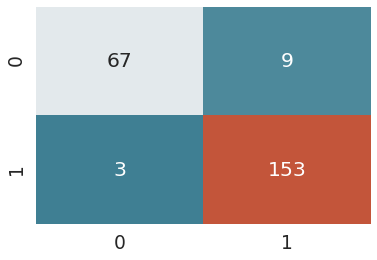

In [46]:
# visualization for 2.1 default threshold (only for normalized data set because it performs much better)
result = convert_reg_to_class(trial_r_n.y_test, dnnr_1.predict(trial_r_n.x_test))
print("Accuracy: ", result['accuracy'])

confusion_matrix_visualization_raw(result['y_data_true'], result['y_data_predict'])
confusion_matrix_visualization_raw(result['y_data_true'], result['y_data_predict'], raw=1)

```
# Result change with re-run. Normalized outperforms.
Accuracy:  0.9482758620689655
```

{'threshold': 2.175, 'accuracy': 0.9525862068965517}
true negatives: 70
false positives: 6
false negatives: 5
true positives: 151


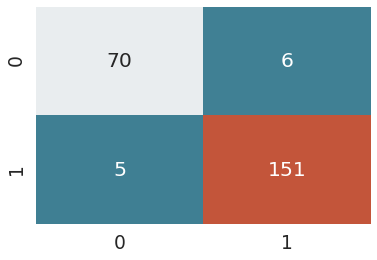

In [47]:
# finding the right threshold and then trying again (might be overfitting
# , which is why finding the right threshold is disencouraged)

best_threshold = {'threshold':0, 'accuracy':0}
for i in range(int(1.8*1000), int(3.0*1000)):
  # testing current threshold
  result = convert_reg_to_class(trial_r_n.y_test, dnnr_1.predict(trial_r_n.x_test), float(i/1000))
  # checking if the current threshold is the best one
  if best_threshold['accuracy'] < result['accuracy']:
    best_threshold = {'threshold':float(i/1000), 'accuracy':result['accuracy']}

print(best_threshold)

# visualizing again, now with the right threshold
result = convert_reg_to_class(trial_r_n.y_test, dnnr_1.predict(trial_r_n.x_test), best_threshold['threshold'])
confusion_matrix_visualization_raw(result['y_data_true'], result['y_data_predict'])
confusion_matrix_visualization_raw(result['y_data_true'], result['y_data_predict'], raw=1)

```
{'threshold': 2.024, 'accuracy': 0.9568965517241379}
```

## 3.8 Regression model: Random Forest regressor

In [48]:
def random_forest_regression(data, n_estimators=[20,50,100,200], max_depth=['None',8,9,10,11], cv=10, n_jobs=-1, verbose=0):
  grid_params = {'max_features': ['auto','sqrt','log2'], 'n_estimators' : n_estimators, 'max_depth' :max_depth, 'criterion': ['mse']}
  gs = GridSearchCV (RandomForestRegressor(), grid_params, verbose = verbose, cv = cv, n_jobs = n_jobs)
  gs_results = gs.fit(data.x_train, data.y_train)
  print(gs.score(data.x_train, data.y_train), gs.score(data.x_test, data.y_test))
  return gs

In [49]:
# testing
rfr_0 = random_forest_regression(trial_r)
rfr_1 = random_forest_regression(trial_r_n)

0.991825762250225 0.9528030057149752
0.9848936199288946 0.8486307521357948


*-> Even though rfr_0 seems to do better, the regression is extremely skewed and performing much worse than rfr_1*

**Visualisation**

Accuracy:  0.9267241379310345


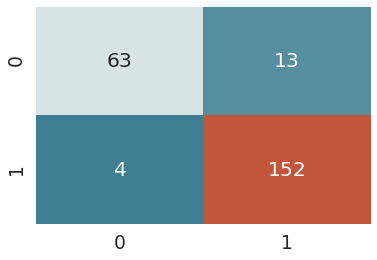

In [50]:
# visualization for 2.1 default threshold (only for normalized data set because it performs much better)
result = convert_reg_to_class(trial_r_n.y_test, rfr_1.predict(trial_r_n.x_test))
print("Accuracy: ", result['accuracy'])

confusion_matrix_visualization_raw(result['y_data_true'], result['y_data_predict'])

{'threshold': 2.186, 'accuracy': 0.9439655172413793}
true negatives: 68
false positives: 8
false negatives: 5
true positives: 151


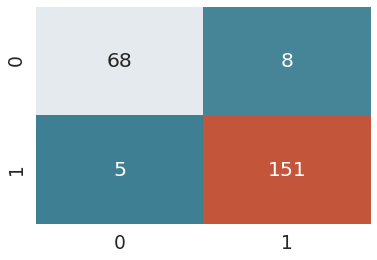

In [51]:
# finding the right threshold and then trying again (might be overfitting
# , which is why finding the right threshold is disencouraged)

best_threshold = {'threshold':0, 'accuracy':0}
for i in range(int(1.8*1000), int(3.0*1000)):
  # testing current threshold
  result = convert_reg_to_class(trial_r_n.y_test, rfr_1.predict(trial_r_n.x_test), float(i/1000))
  # checking if the current threshold is the best one
  if best_threshold['accuracy'] < result['accuracy']:
    best_threshold = {'threshold':float(i/1000), 'accuracy':result['accuracy']}

print(best_threshold)

# visualizing again, now with the right threshold
result = convert_reg_to_class(trial_r_n.y_test, rfr_1.predict(trial_r_n.x_test), best_threshold['threshold'])
confusion_matrix_visualization_raw(result['y_data_true'], result['y_data_predict'])
confusion_matrix_visualization_raw(result['y_data_true'], result['y_data_predict'], raw=1)

## 3.9 NO-ML: Not using a machine learning model at all
Why even use a ML model if the whole system is based on the following conditions:

If ANY of the scores (A,B,Marks,Money_Marks, Loss_Score, history_score) goes above 2, then the risk = 1 *(verified for all scores that each individual one is relevant if there is an entry that has a value 2 for all scores except one)*:
- All scores start at 2
- if Para A is >=1 then Score A = 4
- if Para B is >=1 then *usually* Score B > 2. There are a few exceptions to this but it doesn't make any sense at all (maybe errors in the dataset?). Still, Para B >=1 results in risk=1.
- if numbers is >= 5 then Marks >2
- if money_value > 5 then Money_marks >2
- if loss >0 (can only be 0 or 1) then loss_score = 4
- if history >0 then history_score > 2

Not a score but:
- if district >2 then risk =1

More insights:
- **Total** value does not affect the risk value -> one entry shows this as it has a high value but all other scores are at 2, making it a non-risk company
- Sector_score has no influence on the risk level (that I could identify)

Result:
This algorithm predicts all risk scores correctly except for 12 entries, all of which have the same sector_score of 3.89. That sector has either bribed the auditing company or there is a special condition for some of the companies in this sector not to be audited. **The critical feature for this error is Para_B**

Final accuracy on the whole dataset: 98.3%

In [52]:
# creating new dataset:
trial_no_ml = dataPreprocessing(trial_original, ['PARA_A', 'PARA_B', 'numbers', 'Money_Value', 'Loss', 'History', 'District', 'Sector_score'], test_size=0.0001, fix_skewed=fix_skewed) # all default values. Normalized.

# predefine result and accuracy
print("Variables: ", trial_no_ml.xnames)
result = np.array([])
accuracy = 0
# all conditions
for e,i in enumerate(trial_no_ml.x_train):

  #  PARA_A      PARA_B    numbers  money_value  loss     history   district
  if i[0]>=1 or i[1]>=1 or i[2]>5 or i[3]>=5 or i[4]>0 or i[5]>0 or i[6]>2:
    value = 1
    result = np.append(result, [1])
  else:
    value = 0
    result = np.append(result, [0])

  # check accuracy
  if value == trial_no_ml.y_train[e]:
    accuracy = accuracy + 1
  else:
    print(f"Wrong (pred:{value}, real:{trial_no_ml.y_train[e]}): {i}")

# calculate final accuracy
accuracy = accuracy / len(trial_no_ml.x_train)
print("Accuracy: ", accuracy)

Variables:  ['PARA_A', 'PARA_B', 'numbers', 'Money_Value', 'Loss', 'History', 'District', 'Sector_score']
Wrong (pred:1, real:0.0): [0.   2.97 5.   2.84 0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.   1.05 5.   0.16 0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.   1.03 5.   0.   0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.62 2.02 5.   0.11 0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.74 1.   5.   0.   0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.   2.27 5.   2.62 0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.   1.03 5.   2.43 0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.    1.1   5.    0.007 0.    0.    2.    3.89 ]
Wrong (pred:1, real:0.0): [0.   1.88 5.   0.   0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.   1.61 5.   2.51 0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.   1.02 5.   0.   0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.   1.76 5.   1.08 0.   0.   2.   3.89]
Wrong (pred:1, real:0.0): [0.   4.83 5.   0.94 0.   0.   2.   3.89]
Ac

true negatives: 272
false positives: 13
false negatives: 0
true positives: 486


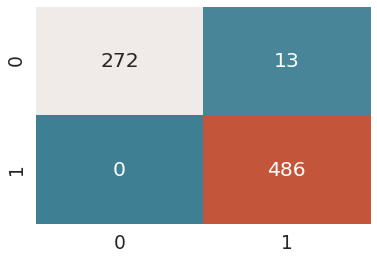

In [53]:
# visualisation
confusion_matrix_visualization_raw(trial_no_ml.y_train, result)
confusion_matrix_visualization_raw(trial_no_ml.y_train, result, raw=1)

# 4 - Results

# 5 - Final remarks

# 6 - Appendix (and code that is not needed anymore but that might be useful to the team)